In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from spider import SPIDER
op = SPIDER()
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import umap

2023-06-24 13:31:20.960610: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-24 13:31:20.970342: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 13:31:21.051822: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-24 13:31:21.052995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 13:31:21.805373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
ds = 'breast_cancer'
data_sets = ["A1", "B1", "C1", "D1", "F1", "G2", "H1"]
pal = {
    'adipose tissue': 'greenyellow',
    'breast glands': 'springgreen',
    'connective tissue': 'darkorange',
    
    'cancer in situ': 'orangered',
    'invasive cancer': 'blueviolet',
    
    'immune infiltrate': 'lightskyblue',
    
    'undetermined': 'grey'
}

main

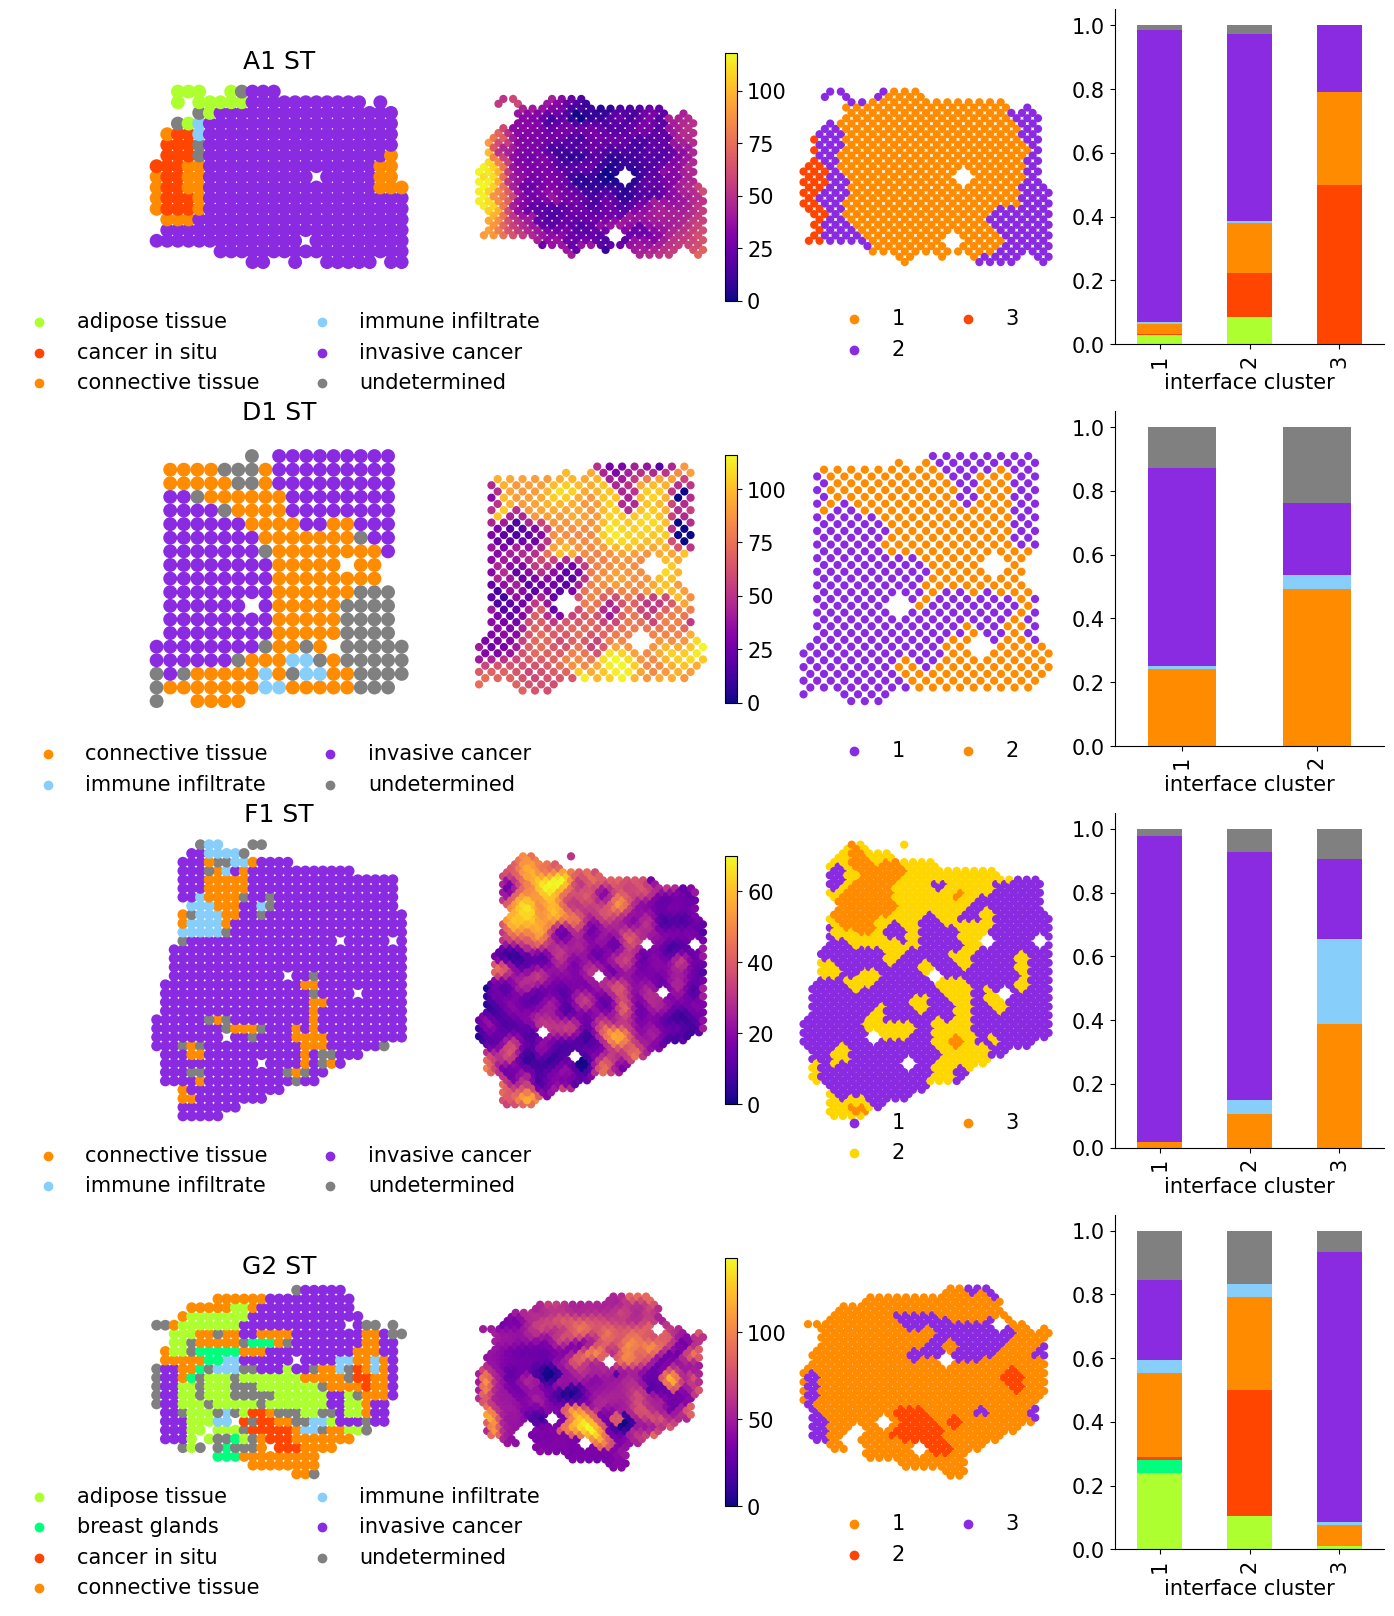

In [8]:
idx = [0, 3, 4, 5]
height = {
    0: 0.8,
    3: 0.95, 
    5: 0.8,
    4: 0.95, 
}
# plt.rcParams['font.size'] = 15
plt.figure(figsize=(4*4, 5*4))
base=1
for i in idx:
    data_name = data_sets[i]
    out_f =  f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    
    if i in [0, 3]:
        spot_size=100
    else:
        spot_size=60
    
    plt.subplot(4,4, base)
    g=sns.scatterplot(data=adata.obs, x='x', y='y', hue ='label', s=spot_size, palette=pal, linewidth=0)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2,frameon =False)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{data_name} ST', y=height[i])
    base += 1
    
    
    
    k = sum(idata.uns['cell_meta'][idata.uns['cell_meta'][adata.uns['cluster_key']] != 'undetermined'][adata.uns['cluster_key']].value_counts() > 20)
    ii = k+2
    j = 20

    
    if i == 8:
        spot_size=60
    elif i == 11:
        spot_size=70
    else:
        spot_size=35
    
    pseudotime = pd.read_csv(f'{out_f}/refined_interface_pseudotime.csv', index_col=0)
    plt.subplot(4, 4, base)
    im=plt.scatter(pseudotime['row'], pseudotime['col'], c=pseudotime['pseudotime_traj1'], s=spot_size, cmap='plasma', edgecolors='none',linewidths=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    base += 1
    
    label_df = pd.read_csv(f'{out_f}refined_interface_label.csv', index_col=0)
    idata.obs['label_spatialPCA'] = label_df.loc[idata.obs_names]['clusterlabel_refine'].to_numpy()
    
    dfs = []
    for i in idata.obs['label_spatialPCA'].unique():
        dfs.append(idata.uns['cell_meta'].loc[np.unique(idata.obs[idata.obs['label_spatialPCA']==i][['A', 'B']].to_numpy().flatten()), 'label'].value_counts())
    dfs_merged = pd.concat(dfs, axis=1)
    dfs_merged.columns=idata.obs['label_spatialPCA'].unique()
    
    if data_name in ['D1', 'G2']:
        top = dfs_merged.idxmax().to_numpy()
        interface_pal = {}
        for i in idata.obs['label_spatialPCA'].unique():
            interface_pal[i] = pal[top[i-1]]
    elif data_name=='A1':
        interface_pal = {1: pal['connective tissue'], 2: pal['invasive cancer'], 3: pal['cancer in situ']}
    elif data_name=='F1':
        interface_pal = {1: pal['invasive cancer'], 2: 'gold', 3: pal['connective tissue']}

        
    plt.subplot(4, 4, base)
    g=sns.scatterplot(data=label_df, x='row', y='col', hue = 'clusterlabel_refine', s=spot_size, palette=interface_pal, linewidth=0)
    g.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2,frameon =False)
    plt.axis('equal')
    plt.axis('off')
    base += 1
    
    ax = plt.subplot(4, 4, base)
    dfs_merged = (dfs_merged / dfs_merged.sum()).T.reset_index().rename(columns={'index':'interface cluster'})
    dfs_merged.plot.bar(x='interface cluster', stacked=True, color=pal, legend=False, ax=ax)
    ax.spines[['right', 'top']].set_visible(False)
    base += 1
plt.savefig(f'../figures/breast_cancer_main.png', bbox_inches="tight",dpi=600)

supp

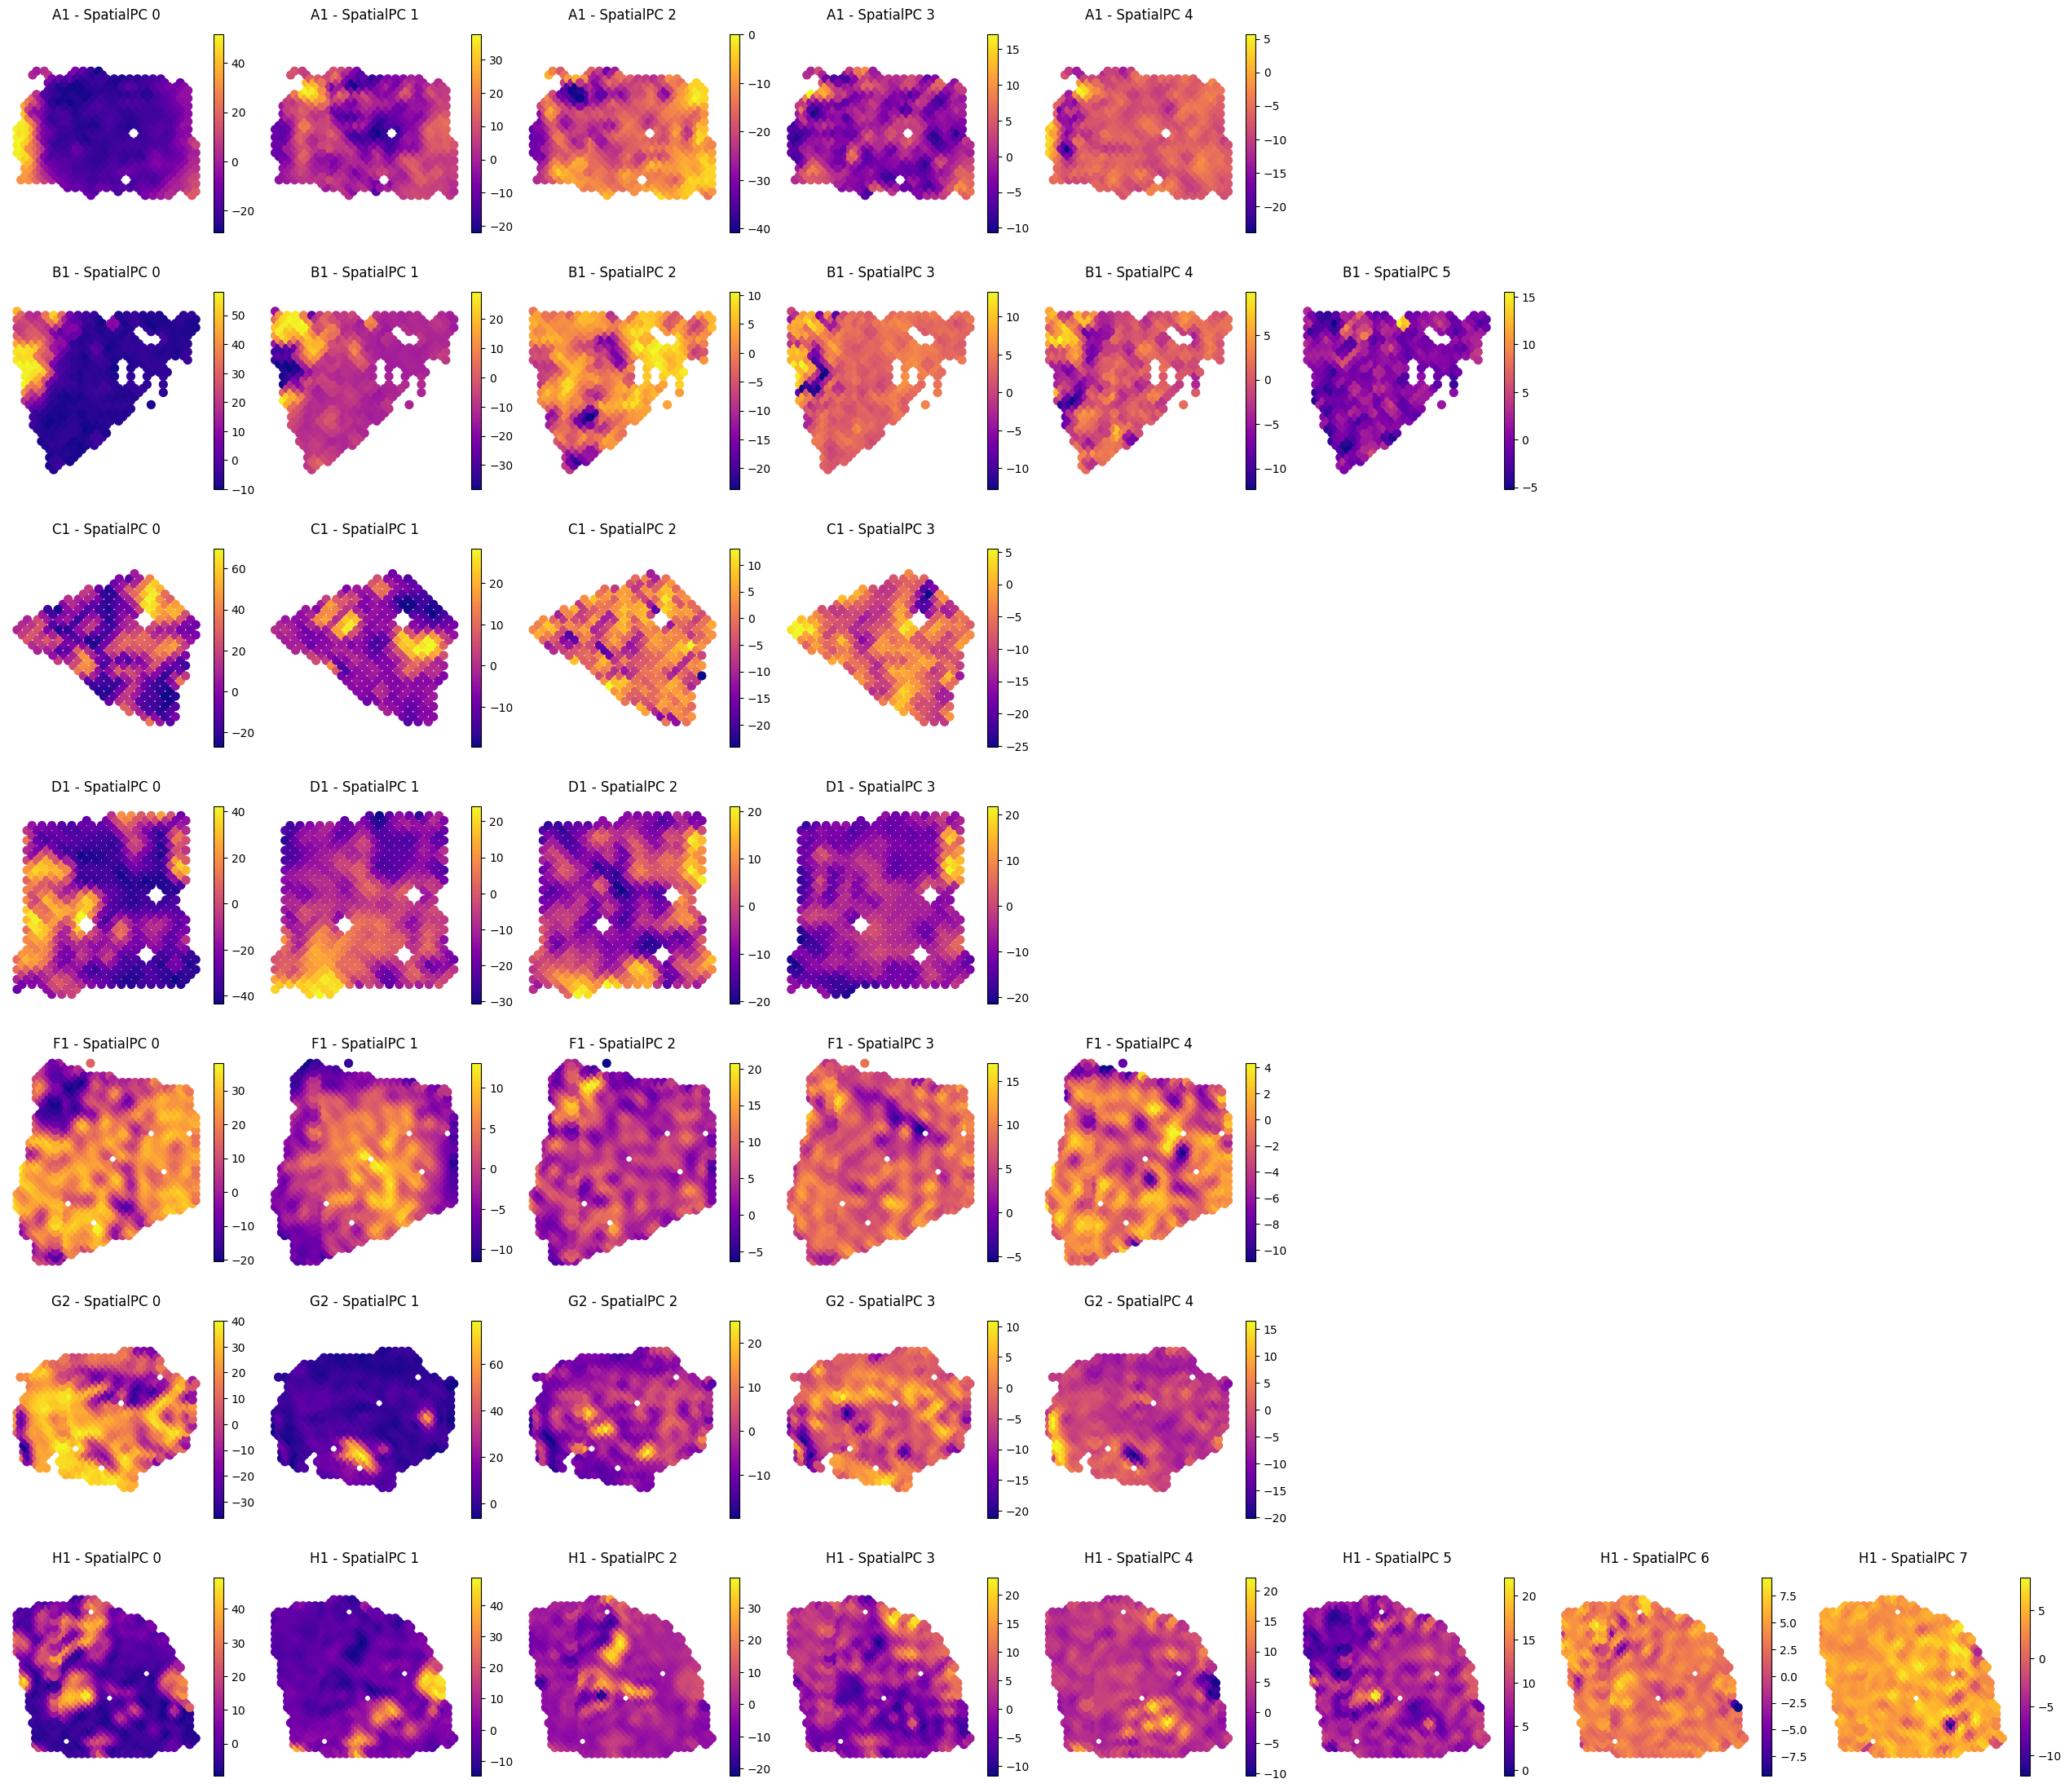

In [45]:
plt.figure(figsize=(32, 28))
base = 1
for input1 in range(len(data_sets)):
    data_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')

    features = pd.read_csv(f'{out_f}interface_SpatialPCs.csv', index_col=0).T
    idata.obsm['spatialPC'] = features.loc[idata.obs_names].to_numpy()
    obsm_key = 'spatialPC'
    base = 1 + input1*8
    for i in range(idata.obsm[obsm_key].shape[1]):
        plt.subplot(len(data_sets), 8, base)
        im=plt.scatter(idata.obs['row'], idata.obs['col'], c=idata.obsm[obsm_key][:,i], s=50, cmap='plasma')
        plt.axis('equal')
        plt.axis('off')
        plt.title(f'{data_name} - SpatialPC {i}')
        plt.colorbar(im,fraction=0.046, pad=0.04)
        base += 1
        
plt.savefig(f'../figures/{ds}_interface_features.pdf', bbox_inches="tight",dpi=300)


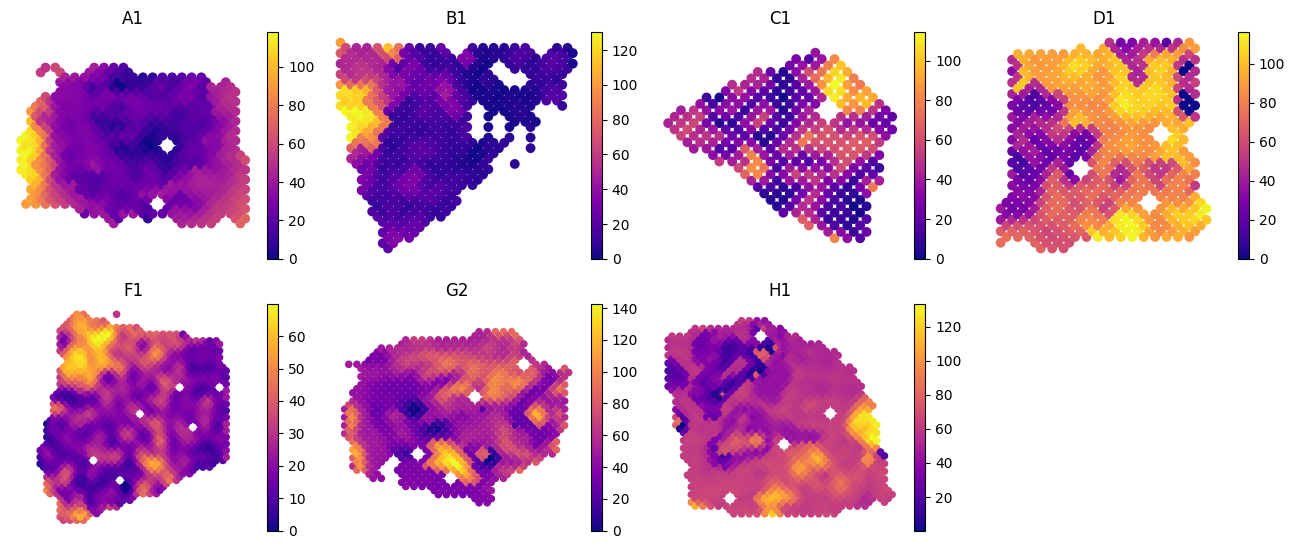

In [50]:

plt.figure(figsize=(16, 10))
base = 1
for input1 in range(len(data_sets)):
    if input1 < 4:
        spot_size=50
    else:
        spot_size=30
    data_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    # idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')

    pseudotime = pd.read_csv(f'{out_f}/refined_interface_pseudotime.csv', index_col=0)
    pseudotime['pseudotime_traj1'] = np.nan_to_num(pseudotime['pseudotime_traj1'])
    plt.subplot(3, 4, base)
    im=plt.scatter(pseudotime['row'], pseudotime['col'], c=pseudotime['pseudotime_traj1'], s=spot_size, cmap='plasma', edgecolors='none',linewidths=0)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.axis('equal')
    plt.axis('off')
    plt.title(f'{data_name}')
    base += 1
plt.savefig(f'../figures/{ds}_refined_interface_pseudotime.pdf', bbox_inches="tight",dpi=300)


In [47]:

plt.figure(figsize=(16, 10))
base = 1
for input1 in range(len(data_sets)):
    data_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    # idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')

    label_df = pd.read_csv(f'{out_f}/refined_interface_label.csv', index_col=0)
    
    idata.obs['label_spatialPCA'] = label_df.loc[idata.obs_names]['clusterlabel_refine'].to_numpy()
    true_label = idata.obs['label'].to_numpy()
    plt.subplot(2, 4, base)
    g=sns.scatterplot(data=label_df, x='row', y='col', hue = 'clusterlabel_refine', s=30, palette='pastel', linewidth=0)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.axis('equal')
    plt.axis('off')
    # plt.title(f'{data_name}:\n{round(adjusted_rand_score(true_label, idata.obs["label_spatialPCA"]), 3)}')
    plt.title(f'{data_name}')
    base += 1
    
plt.savefig(f'../figures/{ds}_refined_interface_clustering.pdf', bbox_inches="tight",dpi=300)
plt.close()

<Figure size 1600x1600 with 0 Axes>

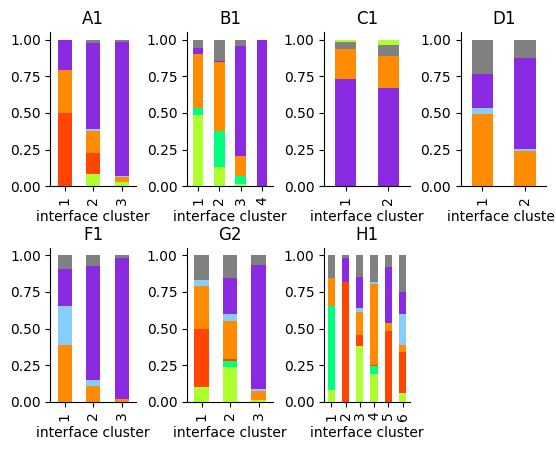

In [48]:

plt.figure(figsize=(16, 16))
fig, axes = plt.subplots(2, 4)
base = 0
for input1 in range(len(data_sets)):
    data_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    # idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')

    label_df = pd.read_csv(f'{out_f}/refined_interface_label.csv', index_col=0)
    idata.obs['label_spatialPCA'] = label_df.loc[idata.obs_names]['clusterlabel_refine'].to_numpy()
    
    dfs = []
    for i in idata.obs['label_spatialPCA'].unique():
        dfs.append(idata.uns['cell_meta'].loc[np.unique(idata.obs[idata.obs['label_spatialPCA']==i][['A', 'B']].to_numpy().flatten()), 'label'].value_counts())
    dfs_merged = pd.concat(dfs, axis=1)
    dfs_merged.columns=idata.obs['label_spatialPCA'].unique()
    dfs_merged = (dfs_merged / dfs_merged.sum()).T
    order = np.dot(dfs_merged, (range(1, len(dfs_merged.columns)+1))).argsort()
    rename_dict = {}
    for i in range(len(dfs_merged.index)):
        rename_dict[dfs_merged.index[order[i]]] = i+1
    dfs_merged = dfs_merged.reset_index().rename(columns={'index':'interface cluster'})
    dfs_merged['interface cluster'] = dfs_merged['interface cluster'].astype('category').cat.rename_categories(rename_dict).cat.reorder_categories(range(1, len(dfs_merged)+1))
    label_df['clusterlabel_refine'] = label_df['clusterlabel_refine'].astype('category').cat.rename_categories(rename_dict).cat.reorder_categories(range(1, len(dfs_merged)+1))
    # g = dfs_merged.sort_values('interface cluster').plot.bar(x='interface cluster', stacked=True, legend=False)
    # g.spines[['right', 'top']].set_visible(False)
    
    dfs_merged.sort_values('interface cluster').plot.bar(x='interface cluster', stacked=True, color=pal, legend=False, ax=axes[int(base/4)][int(base%4)], title=data_name)
    axes[int(base/4)][int(base%4)].spines[['right', 'top']].set_visible(False)
    # plt.title(f'{data_name}:\n{round(adjusted_rand_score(true_label, idata.obs["label_spatialPCA"]), 3)}')
    # plt.title(f'{data_name}')
    base += 1
fig.delaxes(axes[int(base/4)][int(base%4)])
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(wspace=0.6) 
plt.savefig(f'../figures/{ds}_refined_interface_clustering_barplot.pdf', bbox_inches="tight",dpi=300)

In [4]:
marker_dfs = []
enr_dfs = []
enr_dfs_full = []
enr_dfs_node = []
for input1 in range(len(data_sets)):
    data_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{data_name}/'
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    label_df = pd.read_csv(f'{out_f}/refined_interface_label.csv', index_col=0)
    idata.obs['label_spatialPCA'] = label_df.loc[idata.obs_names]['clusterlabel_refine'].astype(str).astype('category')
    sc.tl.rank_genes_groups(idata, groupby='label_spatialPCA', method='wilcoxon')
    marker_df = op.util.get_marker_df(idata, logfoldchanges_threhold=5)
    marker_df['sample'] = data_name
    marker_dfs.append(marker_df.copy())
    # sc.pl.rank_genes_groups_dotplot(idata, n_genes=5,values_to_plot='logfoldchanges', min_logfoldchange=5, vmax=np.abs(marker_df['logfoldchanges'].max()), vmin=-np.abs(marker_df['logfoldchanges'].max()), cmap='bwr', save=f'{data_name}_marker_dot.pdf')
    # sc.pl.spatial(idata, color=list(idata.uns['rank_genes_groups']['names'][:1].flatten()[0]), spot_size=0.8, save=f'{data_name}_marker_exp.pdf')
    custom, background = op.er.pathway_prep(idata)
    marker_df['g'] = marker_df['names']
    marker_df['membership'] = 1
    # marker_df.to_csv(f'./tables/{data_name}_marker.csv')
    merged_df_edge, arr = op.er.enrichment(custom, background, marker_df.set_index('names'), groupby='cluster')
    merged_df_edge['sample'] = data_name
    enr_dfs_full.append(merged_df_edge)
    merged_df_edge = merged_df_edge[merged_df_edge["Adjusted P-value"]<=0.05]
    enr_dfs.append(merged_df_edge)
    # .to_csv(f'./tables/{data_name}_marker_edge_enrichment.csv')
    # merged_df_edge.to_csv(f'./tables/{data_name}_marker_edge_enrichment_full.csv')
    merged_df, arr = op.er.enrichment_interacrtion_gene_df(marker_df.set_index('names'), groupby='cluster')
    merged_df = merged_df[merged_df["Adjusted P-value"]<=0.05]
    merged_df['sample'] = data_name
    enr_dfs_node.append(merged_df)
    
pd.concat(marker_dfs).to_csv(f'../tables/{ds}_markers.csv')
pd.concat(enr_dfs).to_csv(f'../tables/{ds}_edge_enrichment.csv')
pd.concat(enr_dfs_node).to_csv(f'../tables/{ds}_node_enrichment.csv')
pd.concat(enr_dfs_full).to_csv(f'../tables/{ds}_edge_enrichment_full.csv')

3    139
1     52
2     19
Name: cluster, dtype: int64
Using human LR pair dataset.
4    175
1     93
2     42
3     35
Name: cluster, dtype: int64
Using human LR pair dataset.
2    24
1    14
Name: cluster, dtype: int64
Using human LR pair dataset.
1    17
2    11
Name: cluster, dtype: int64
Using human LR pair dataset.
3    67
1    42
2    19
Name: cluster, dtype: int64
Using human LR pair dataset.
2    127
3    123
1    109
Name: cluster, dtype: int64
Using human LR pair dataset.
2    145
6    135
4     86
3     76
1     64
5     34
Name: cluster, dtype: int64
Using human LR pair dataset.


svi supp

In [7]:
ds = 'breast_cancer'
for input1 in range(len(data_sets)):
    sample_name = data_sets[input1]
    out_f = f'../datasets/{ds}/{sample_name}/'
    adata = anndata.read_h5ad(f'{out_f}/adata.h5ad')
    idata = anndata.read_h5ad(f'{out_f}/idata.h5ad')
    
    svi_df, svi_df_strict = op.svi.combine_SVI(idata,threshold=0.01)
    op.svi.eva_SVI(idata, svi_df_strict)
    plt.savefig(f'../figures/{ds}_{sample_name}_metric.png', dpi=300,bbox_inches='tight')
    plt.close()
    
    op.util.adata_moranI(adata, out_f=out_f)
    merged_df,lri_pw_list,gene_lr_list,gene_pw_list = op.vis.svg_svi_relation(adata, idata, title=sample_name, is_human=adata.uns['is_human'], top=50)
    plt.savefig(f'../figures/{ds}_{sample_name}_relation.png', dpi=600,bbox_inches='tight')
    plt.close()
    
    import gseapy
    membership=pd.get_dummies(merged_df.set_index('Term')['group']).groupby('Term').sum().astype(str).agg('-'.join, axis=1)
    merged_df['group name'] = membership.loc[merged_df.Term].to_numpy()
    rename_dict = {
        '1-0-0': 'LR', '1-0-1':'SVI&LR', '0-0-1':'SVI', '1-1-1':'All', '0-1-0':'SVG', '0-1-1':'SVI&SVG', '1-1-0':'LR&SVG','0-1':'SVI','1-1': 'SVI&LR'
    }
    merged_df['group name'] = merged_df['group name'] .astype('category').cat.rename_categories(rename_dict).to_numpy()
    if sample_name in ['A1','B1','C1']:
        op.vis.enrichment(merged_df,x_key='group name', cutoff=0.05, top_term=20,size=15,save=f'../figures/{ds}_{sample_name}_relation_enrichment.png',figsize=(3,15))
    else:
        op.vis.enrichment(merged_df,x_key='group name', cutoff=0.05, top_term=20,size=15,save=f'../figures/{ds}_{sample_name}_relation_enrichment.png')
            
    op.vis.pattern_LRI(idata,show_SVI=10, spot_size=80)
    plt.tight_layout()
    plt.savefig(f'../figures/{ds}_{sample_name}_patterns.png', dpi=600,bbox_inches='tight')
    plt.close()
    
    op.svi.eva_pattern(idata)
    plt.savefig(f'../figures/{ds}_{sample_name}_pattern_metric.png', dpi=600,bbox_inches='tight')
    plt.close()
    
    merged_df_edge, arr = op.er.pattern_enrichment_edge(idata,is_human=adata.uns['is_human'])
    merged_df_node, arr = op.er.pattern_enrichment_node(idata,is_human=adata.uns['is_human'])
    op.vis.enrichment(merged_df_node,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_node.png',size=15)
    try:
        op.vis.enrichment(merged_df_edge,x_key='label', cutoff=0.05, top_term=20,save=f'../figures/{ds}_{sample_name}_pattern_enrichment_edge.png')
    except Exception as e:
        print(e)
    
    idata = idata[:, idata.var['is_svi']==1]
    adata, adata_lri, adata_pattern = op.cell_transform(idata, adata, label=adata.uns['cluster_key'])
    
    with plt.rc_context():
        sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI.png', bbox_inches="tight")
        plt.close()
        
    with plt.rc_context():
        sc.pl.rank_genes_groups_dotplot(adata_lri, standard_scale='var', n_genes=1, show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_SVI1.png', bbox_inches="tight")
        plt.close()
        
    with plt.rc_context(): 
        sc.pl.rank_genes_groups_dotplot(adata_pattern, standard_scale='var', n_genes=1, show=False, cmap='plasma')
        plt.savefig(f'../figures/{ds}_{sample_name}_label_pattern.png', bbox_inches="tight")
        plt.close()



Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
351/621 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Geary
C (rev.)_SVI vs. Geary
C (rev.)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.762e-78 U_stat=8.875e+04
Moran
I_SVI vs. Moran
I_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.302e-78 U_stat=8.884e+04
FSV
(SOMDE)_SVI vs. FSV
(SOMDE)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.926e-07 U_stat=5.864e+04
LR
(SOMDE)_SVI vs. LR
(SOMDE)_Excluded: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.731e-46 U_stat=7.894e+04
LR
(nnSVG)_SVI vs. LR

100%|██████████| 1000/1000 [00:10<00:00, 93.16/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.40325160969041735 0.24007673295547033 0.09777406881821946
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.609e-07 U_stat=5.800e+01
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.592e-04 U_stat=0.000e+00
2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.216e-56 U_stat=1.074e+03
3_no vs. 3_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.967e-33 U_stat=3.010e+02
4_no vs. 4_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.576e-02 U_stat=0.000e+00
5_no vs. 5_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:

100%|██████████| 1000/1000 [00:03<00:00, 289.91/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.7235877877919006 0.4846699840507118 0.20857533899187317
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.911e-08 U_stat=1.450e+02
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.419e-03 U_stat=1.000e+00
2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.055e-12 U_stat=5.900e+02
3_no vs. 3_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.739e-23 U_stat=1.590e+02
4_no vs. 4_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.548e-41 U_stat=1.551e+03
5_no vs. 5_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.

100%|██████████| 1000/1000 [00:02<00:00, 476.67/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.5561353027814623 0.40642108550050227 0.21802025054964308
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.569e-134 U_stat=1.760e+02
3_no vs. 3_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.703e-57 U_stat=5.327e+03
4_no vs. 4_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.854e-64 U_stat=1.568e+04
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.027e-05 U_stat=1.880e+02
1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.503e-35 U_stat=3.901e+03
Using human LR pair dataset.
Added key cell_pattern in idata.uns
Added key cell_score in idata.

100%|██████████| 1000/1000 [00:03<00:00, 278.99/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.4807382627603038 0.39676884759346925 0.17198744719779477
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.864e-09 U_stat=4.800e+01
3_no vs. 3_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.879e-07 U_stat=2.500e+01
4_no vs. 4_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.736e-03 U_stat=0.000e+00
5_no vs. 5_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.112e-29 U_stat=3.840e+04
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.469e-52 U_stat=5.700e+02
1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1

100%|██████████| 1000/1000 [00:07<00:00, 127.24/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.25646479797252686 0.1299021444826447 0.08516024046575496
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.060e-45 U_stat=1.017e+03
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.311e-30 U_stat=1.000e+00
Using human LR pair dataset.
Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction_pattern_groups in adata.uns
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
592/736 SVIs identified (threshold=0.01).
evaluating with ['moranI' 'gearyC' 'SOMDE' 'nnSVG']
p-va

100%|██████████| 1000/1000 [00:05<00:00, 187.50/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.4414425487462207 0.33053868699011174 0.1594817502623687
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

8_yes vs. 8_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=6.061e+04
1_yes vs. 1_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=2.819e+04
0_yes vs. 0_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=9.059e+04
2_yes vs. 2_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=2.179e+04
3_yes vs. 3_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.000e+00 U_stat=6.800e+04
4_yes vs. 4_no: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.

100%|██████████| 1000/1000 [00:14<00:00, 70.58/s]


Human KEGG_2021_Human
Using human LR pair dataset.
50
0.4007700182003554 0.3085161390552023 0.13212960547348823
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_no vs. 1_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.530e-40 U_stat=1.800e+01
0_no vs. 0_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.143e-04 U_stat=4.100e+01
2_no vs. 2_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.525e-15 U_stat=9.100e+01
3_no vs. 3_yes: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.994e-43 U_stat=6.791e+03
Using human LR pair dataset.
Added key cell_pattern in idata.uns
Added key cell_score in idata.uns
Added key interaction_pattern, interaction_score in adata.obsm
Added key rank_interaction_score_groups, rank_interaction